## Proyecto final: Notebook 2

### David Tejeda - 9170350
### Juan Hernández - 9710120
### Mario Tabarini - 22000349


In [34]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from sklearn.linear_model import LinearRegression

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import scipy.stats as stats
from IPython.display import display, HTML

import joblib


### Importando dataset para aplicar ingeniería de características

In [35]:
data = pd.read_csv('HR_employee_attrition_2.csv') #Se importa acrhivo .CSV
data.shape

(1470, 35)

# Ingeniería de características

### Detectando valores nulos

In [36]:
cols_con_na = [col for col in data.columns if (data[col].isnull().mean() > 0)] #Se crea un dataset con las columnas que cuentan con valores nulos
cols_con_na

['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'EducationField',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'MaritalStatus',
 'MonthlyRate',
 'NumCompaniesWorked',
 'Over18',
 'OverTime']

#### Determinando la proporción de faltantes para cada columna con faltantes

In [37]:
prop_nan_per_col = data[cols_con_na].isnull().mean() #Se determina la proporción de nulos para cada columna del dataset que tiene nulos
prop_nan_per_col

Age                        0.006803
Attrition                  0.012925
BusinessTravel             0.038095
DailyRate                  0.025170
Department                 0.297959
EducationField             0.003401
EmployeeCount              0.085034
EmployeeNumber             0.009524
EnvironmentSatisfaction    0.027891
Gender                     0.368027
HourlyRate                 0.009524
JobInvolvement             0.010204
JobLevel                   0.048299
MaritalStatus              0.026531
MonthlyRate                0.025170
NumCompaniesWorked         0.012245
Over18                     0.138776
OverTime                   0.009524
dtype: float64

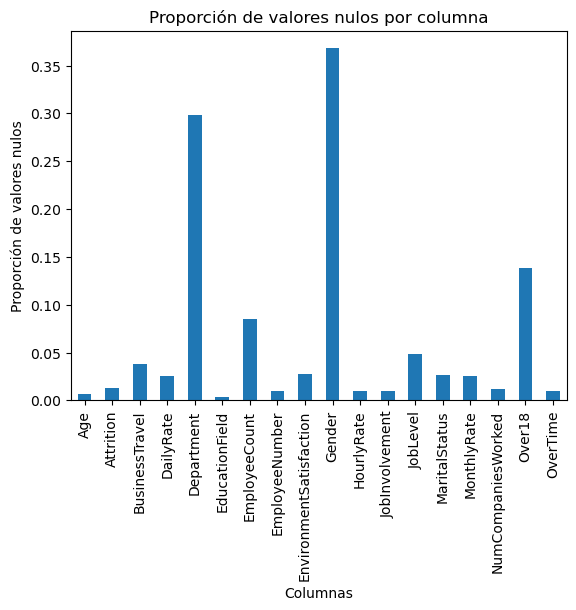

In [38]:
prop_nan_per_col.plot(kind='bar') #Se crea gráfica de barras de proporción de nulos
plt.xlabel('Columnas')
plt.ylabel('Proporción de valores nulos')
plt.title('Proporción de valores nulos por columna')

plt.show() # Se muestra la gráfica


### Evaluando tipos de datos para imputación de variables

In [39]:
data[cols_con_na].dtypes

Age                        float64
Attrition                   object
BusinessTravel              object
DailyRate                  float64
Department                  object
EducationField              object
EmployeeCount              float64
EmployeeNumber             float64
EnvironmentSatisfaction    float64
Gender                      object
HourlyRate                 float64
JobInvolvement             float64
JobLevel                   float64
MaritalStatus               object
MonthlyRate                float64
NumCompaniesWorked         float64
Over18                      object
OverTime                    object
dtype: object

In [40]:
cols_rescatables = [col for col in data.columns if (data[col].isnull().mean() <= 0.05)] #Se crea un dataset que incluya las columnas para las que es posible realizar imputación y no afecte a más del 5%.
cols_rescatables

['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [41]:
cols_drop=[col for col in data.columns if (data[col].isnull().mean()>0.05)] # Se crea un dataset con las columnas que se eliminarán por la alta proporción de valores nulos
cols_drop

['Department', 'EmployeeCount', 'Gender', 'Over18']

In [42]:
data_noNAN = data.drop(cols_drop, axis=1) #Se crea dataset nuevo con las columnas que no tienen faltantes y las que tienen menos del 5% de faltantes 
data_noNAN.shape

(1470, 31)

### Imputación de media en columnas numéricas

In [43]:
for columna in cols_rescatables: # Se recorre listado de columnas numércias con menos de 5% de faltantes y se imputa la media
    if data_noNAN[columna].dtype=='float64' or data_noNAN[columna].dtype=='int64':
        media = data_noNAN[columna].mean()
        data_noNAN[columna]=np.round(data_noNAN[columna].fillna(media))

### Imputación de moda en variables categóricas con menos del 5% de faltantes

In [44]:
def getCategoryVars(dataset): # Función para filtrar variables categóricas del dataset
     cat_colnames = []
     colnames = dataset.columns
     for col in colnames: # Se crea listado de variables categóricas
          if(dataset[col].dtype == 'object'):
               cat_colnames.append(col)
     return cat_colnames

In [45]:
cat_cols = getCategoryVars(data_noNAN) # Se envía a función anterior el dataset con menos de 5% de faltantes
cat_cols

['Attrition',
 'BusinessTravel',
 'EducationField',
 'JobRole',
 'MaritalStatus',
 'OverTime']

In [46]:
dataset_categories = data_noNAN[cat_cols] # Se muestran columnas categóricas
dataset_categories.head()

,Attrition,BusinessTravel,EducationField,JobRole,MaritalStatus,OverTime
0,Yes,Travel_Rarely,Life Sciences,Sales Executive,Single,Yes
1,No,Travel_Frequently,Life Sciences,Research Scientist,Married,No
2,Yes,Travel_Rarely,Other,Laboratory Technician,Single,Yes
3,No,Travel_Frequently,Life Sciences,Research Scientist,Married,Yes
4,No,Travel_Rarely,Medical,Laboratory Technician,Married,No


In [47]:
for columna in dataset_categories: # Se recorre listado de variables categóricas para imputar moda
    if data_noNAN[columna].dtype==object:
        moda = data_noNAN[columna].mode()[0] # Se añade [0] para obtener el valor con mayor frecuencia de la tupla que se genera de la moda
        data_noNAN[columna]=data_noNAN[columna].astype(object) # Se asegura que el valor de la moda es de tipo object
        data_noNAN[columna].fillna(moda, inplace=True)

In [48]:
cols_con_na = [col for col in data_noNAN.columns if (data_noNAN[col].isnull().mean() > 0)] # Se recorre listado de columnas para confirmar si queda algún valor faltante
cols_con_na

prop_nan_per_col = data_noNAN[cols_con_na].isnull().mean()

##### Frequency encoding

In [49]:
for col in dataset_categories: # Se codifica por frecuencia cada variable categórica
    if data_noNAN[col].dtype==object:
        data_noNAN[col].value_counts().sort_values(ascending=False)
        freq_mapper = data_noNAN[col].value_counts().to_dict()
        #freq_mapper[col] = (data_noNAN[col].value_counts().sort_values(ascending=False)).to_dict()
        data_noNAN[col] = data_noNAN[col].map(freq_mapper)

In [50]:
data_noNAN.head() # Se evalúa el resultado

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.0,233,1054,1102.0,1,2,608,1.0,2.0,94.0,...,1,80,0,8,0,1,6,4,0,5
1,49.0,1237,269,279.0,8,1,608,2.0,3.0,61.0,...,4,80,1,10,3,3,10,7,1,7
2,37.0,233,1054,1373.0,2,2,82,4.0,4.0,92.0,...,2,80,0,7,3,3,0,0,0,0
3,33.0,1237,269,1392.0,3,4,608,5.0,4.0,56.0,...,3,80,0,8,3,3,8,7,3,0
4,37.0,1237,1054,591.0,2,1,462,7.0,1.0,40.0,...,4,80,1,6,3,3,2,2,2,2


#### Normalización y transformación de variables 

In [51]:
data_noNAN.describe() # Se evalúa nuevo dataset

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.919728,1077.862585,819.650340,804.804762,9.192517,2.912925,430.793197,1024.797959,2.735374,65.881633,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.088721,366.797999,374.440246,397.737878,8.106864,1.024165,197.759494,602.023763,1.077671,20.249018,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,233.000000,147.000000,102.000000,1.000000,1.000000,27.000000,1.000000,1.000000,30.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,1237.000000,269.000000,477.000000,2.000000,2.000000,159.000000,491.250000,2.000000,48.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,1237.000000,1054.000000,805.000000,7.000000,3.000000,462.000000,1020.500000,3.000000,66.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1237.000000,1054.000000,1152.500000,14.000000,4.000000,608.000000,1555.750000,4.000000,83.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1237.000000,1054.000000,1499.000000,29.000000,5.000000,608.000000,2068.000000,4.000000,100.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [52]:
def getColumnTypes(data_noNAN): #Función para determinar el tipo de dato en columnas del dataset. Si es numérica con más de 30 datos se clasifica como continua
     continuas = []
     discretas = []
     categoricas = []
     for col in data_noNAN.columns:
          if((data_noNAN[col].dtype == 'int64') or (data_noNAN[col].dtype == 'float64')):
               if(len(data_noNAN[col].unique()) > 30): 
                    continuas.append(col)
               else:
                    discretas.append(col)
          else:
               categoricas.append(col)

     return continuas, discretas, categoricas

continuas, discretas, categoricas = getColumnTypes(data_noNAN)

In [53]:
data_temp = data.copy()[continuas] #Se crea un dataset con datos temporales en el que se encuentran únicamente las variables continuas

In [54]:
scaler = StandardScaler() #Se llama a método de librería para normalizar datos
scaler.fit(data_temp)

data_scaled = scaler.transform(data_temp) #Se escala la data temporal
data_scaled = pd.DataFrame(data_scaled, columns=data_temp.columns)

In [55]:
round(data_scaled.describe(), 2) #Se muestra data escalada/normalizada

,Age,DailyRate,EmployeeNumber,HourlyRate,MonthlyIncome,MonthlyRate,TotalWorkingYears,YearsAtCompany
count,1460.00,1433.00,1456.00,1456.00,1470.00,1433.00,1470.00,1470.00
mean,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.08,-1.75,-1.69,-1.76,-1.17,-1.72,-1.45,-1.14
25%,-0.76,-0.83,-0.89,-0.88,-0.76,-0.86,-0.68,-0.65
50%,-0.10,0.00,-0.02,0.01,-0.34,-0.01,-0.16,-0.33
75%,0.67,0.89,0.89,0.85,0.40,0.86,0.48,0.33
max,2.53,1.72,1.73,1.68,2.87,1.78,3.69,5.39


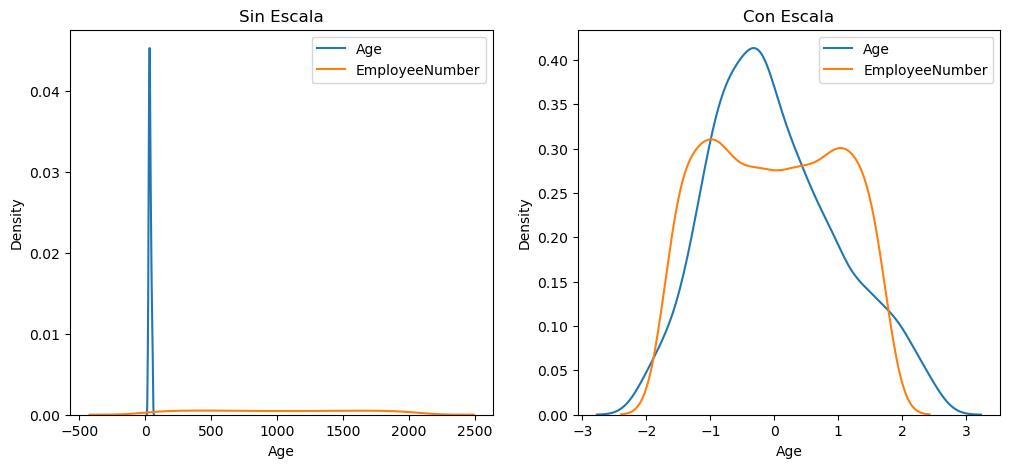

In [56]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))


#Gráficas que permiten evaluar el antes y después de la normalización para dos columnas del dataset
ax1.set_title("Sin Escala")
sns.kdeplot(data_temp['Age'], ax=ax1, label="Age")
sns.kdeplot(data_temp['EmployeeNumber'], ax=ax1, label="EmployeeNumber")

ax2.set_title("Con Escala")
sns.kdeplot(data_scaled['Age'], ax=ax2, label="Age")
sns.kdeplot(data_scaled['EmployeeNumber'], ax=ax2, label="EmployeeNumber")

ax1.legend()
ax2.legend()

plt.show()

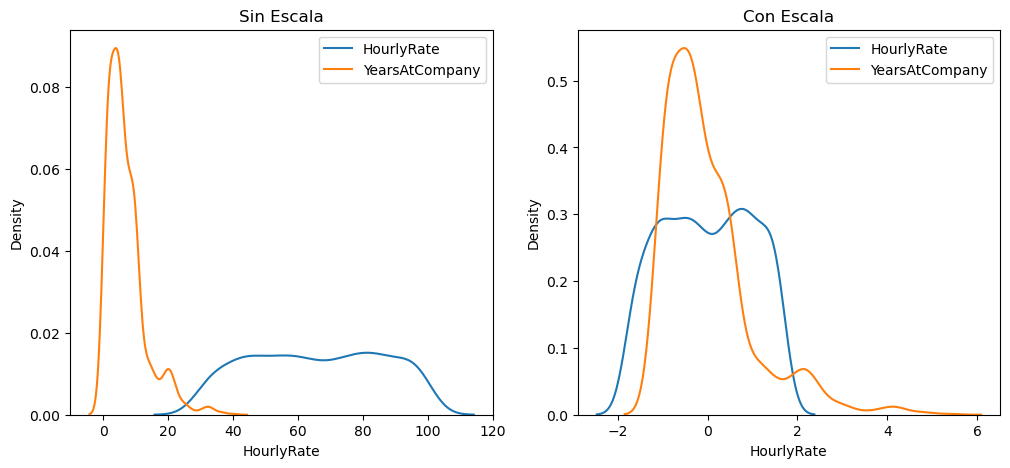

In [57]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))


#Gráfica que compara antes y después entre otro conjunto de columnas para ejemplificar y evidenciar la efectividad de la normalización
ax1.set_title("Sin Escala")
sns.kdeplot(data_temp['HourlyRate'], ax=ax1, label="HourlyRate")
sns.kdeplot(data_temp['YearsAtCompany'], ax=ax1, label="YearsAtCompany")

ax2.set_title("Con Escala")
sns.kdeplot(data_scaled['HourlyRate'], ax=ax2, label="HourlyRate")
sns.kdeplot(data_scaled['YearsAtCompany'], ax=ax2, label="YearsAtCompany")

ax1.legend()
ax2.legend()

plt.show()

## Outliers

### Evaluando visualmente la distribución actual de las variables para detectar outliers

In [58]:
def plotDistBoxQQ(dataset, col): # Se genera una gráfica de distribución, boxplot y QQ-Plot para evaluar outliers visualmente.
               
     plt.figure(figsize=(20, 6))
     plt.subplot(1, 3, 1)
     sns.distplot(dataset[col], bins=30)
     plt.title("Histograma y densisdad")

     plt.subplot(1, 3, 2)
     sns.boxplot(y=dataset[col])
     plt.title("Boxplot")

     plt.subplot(1, 3, 3)
     stats.probplot(dataset[col], dist="norm", plot=plt)
     plt.title("Q-Q Plot")

c:\Users\Mario T\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


c:\Users\Mario T\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Mario T\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Mario T\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

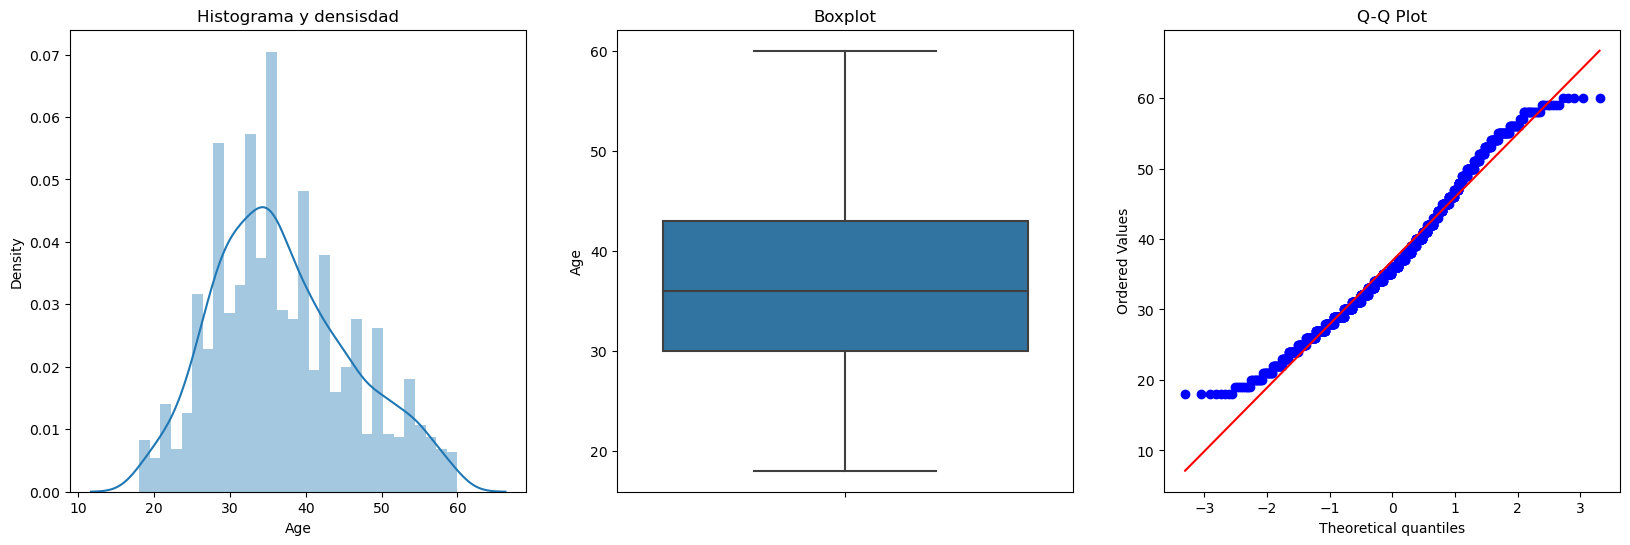

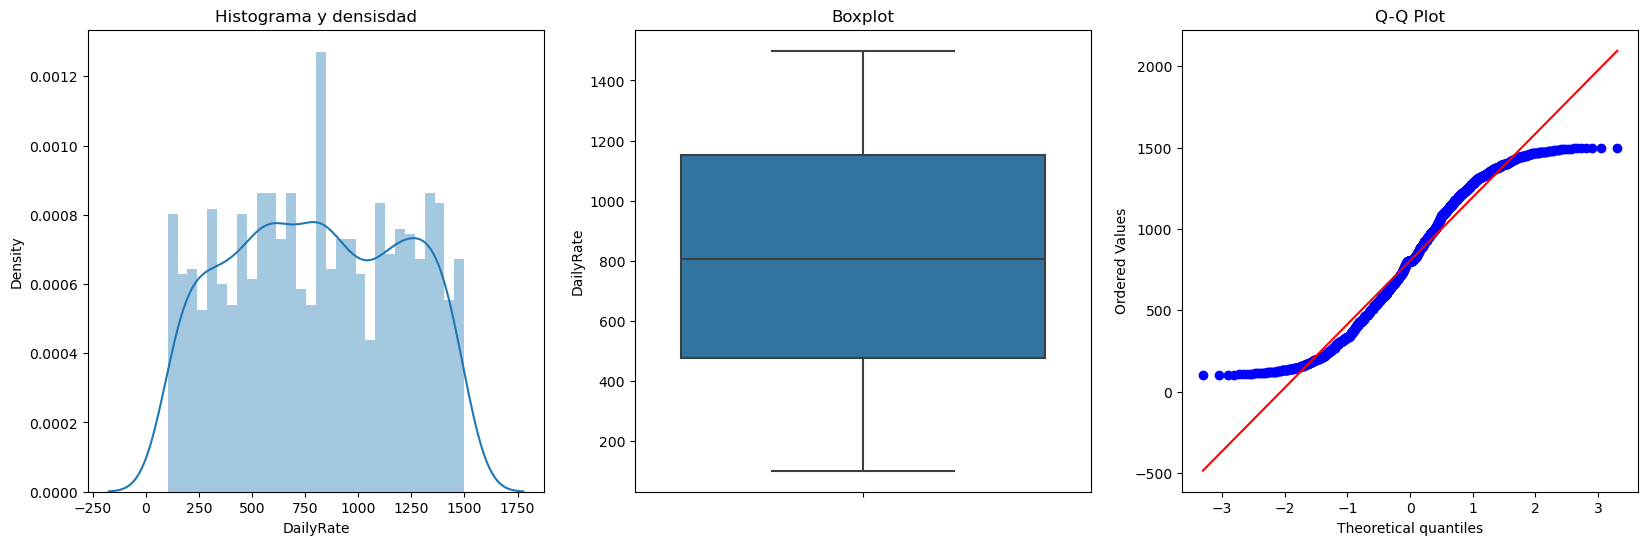

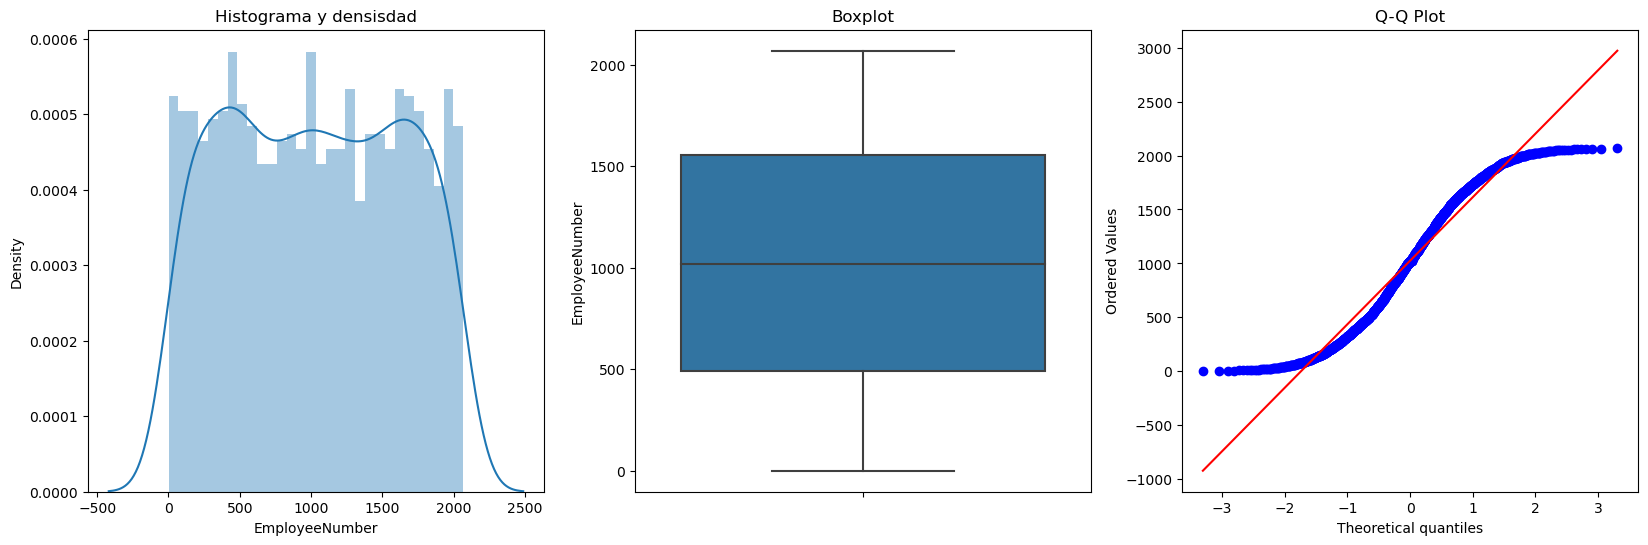

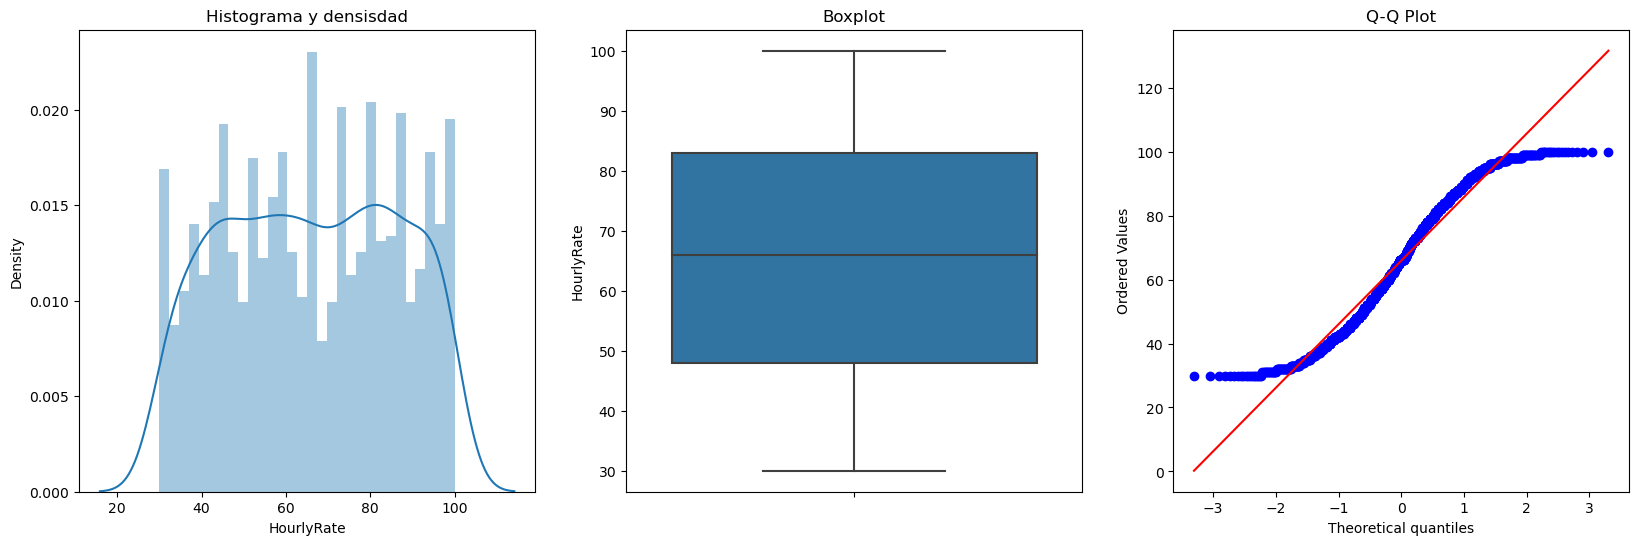

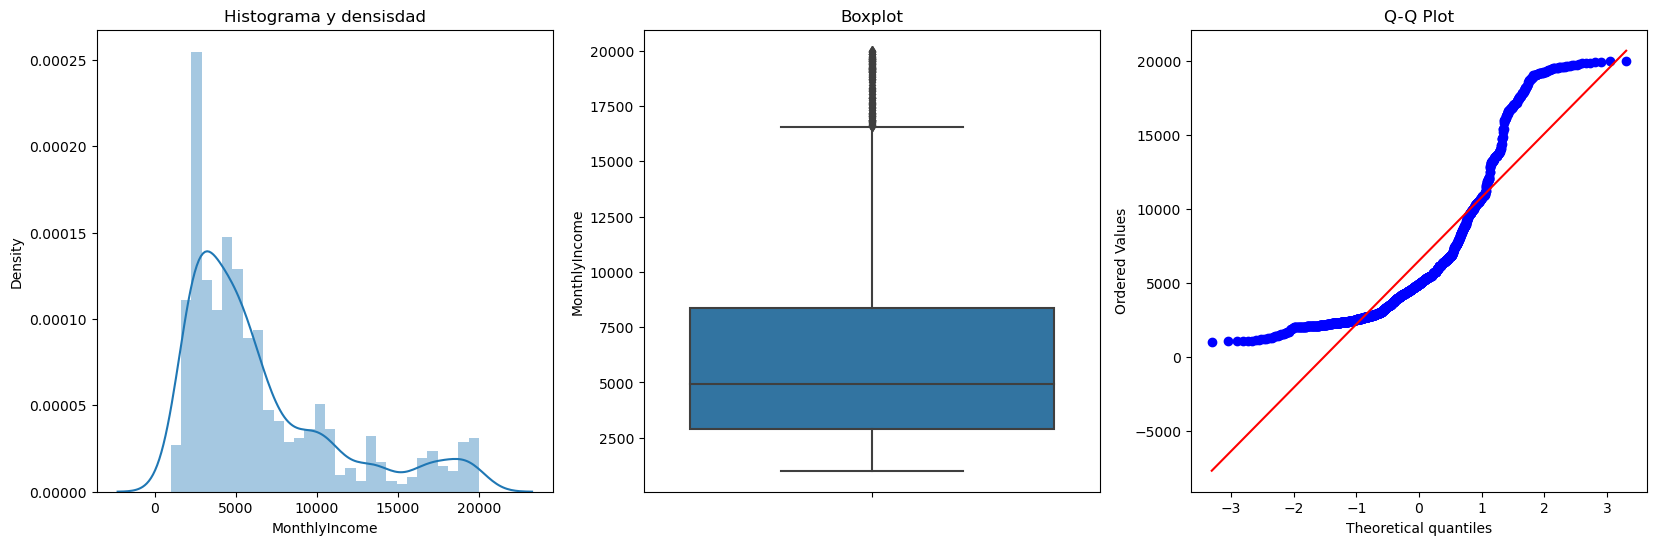

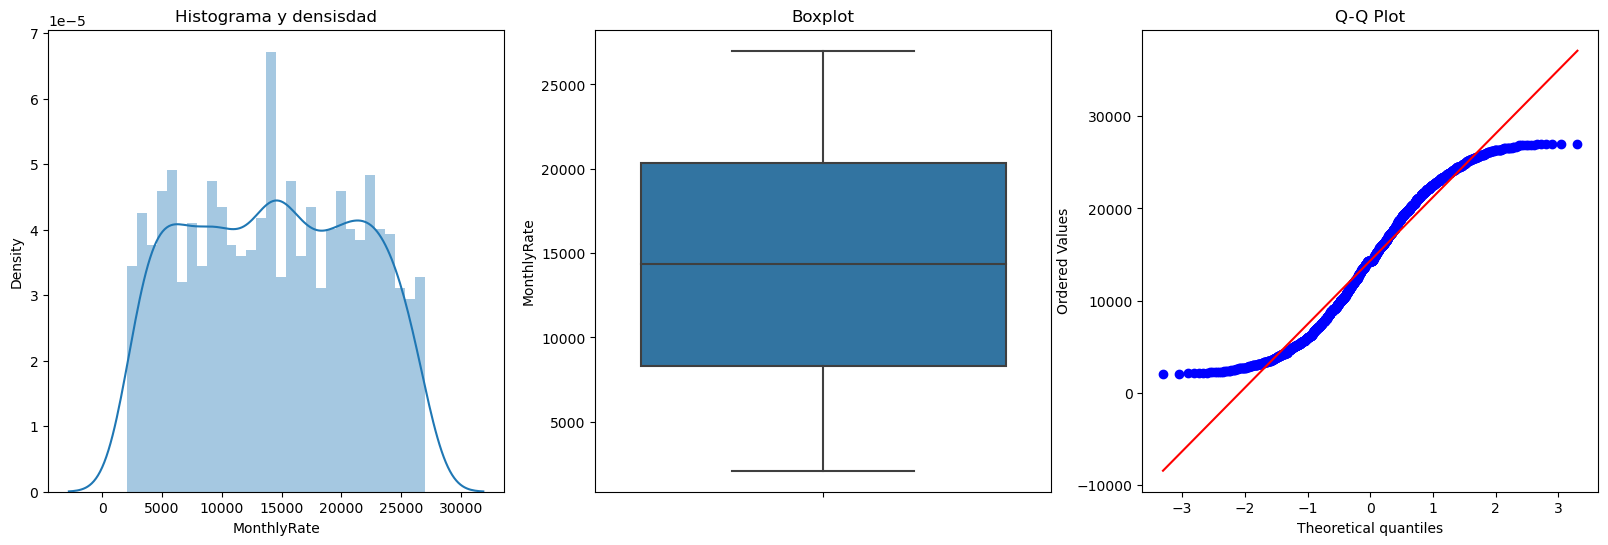

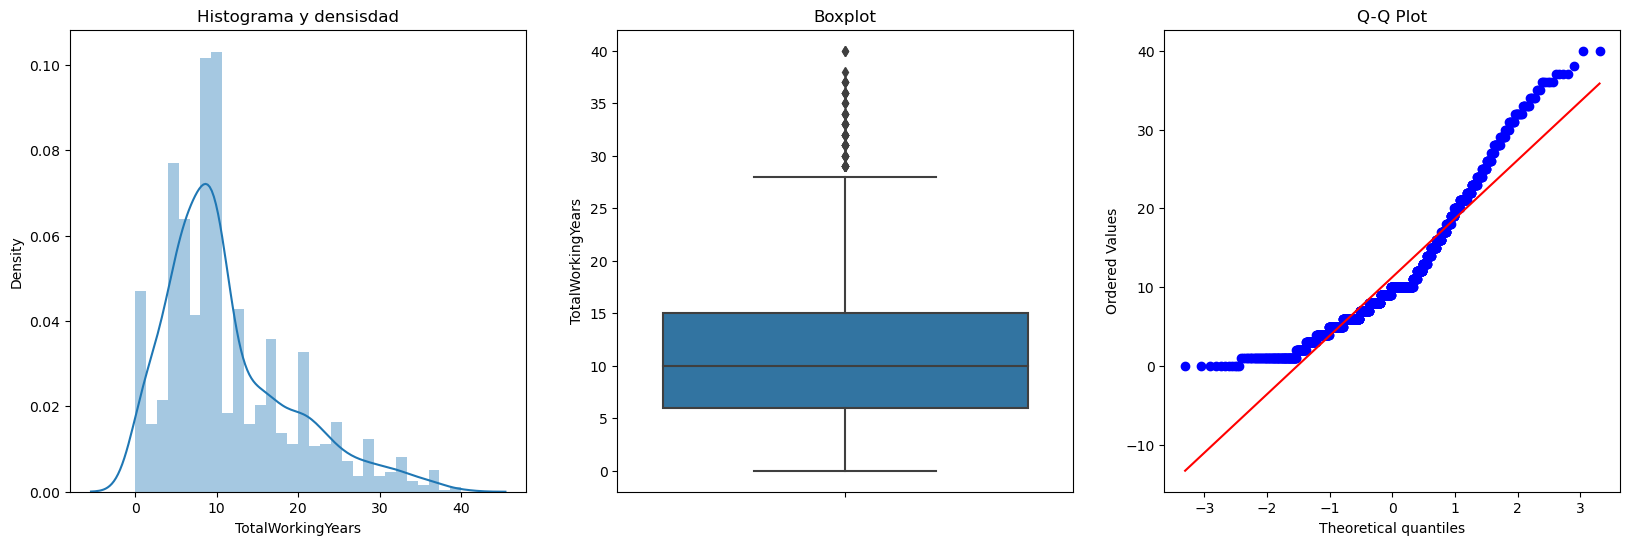

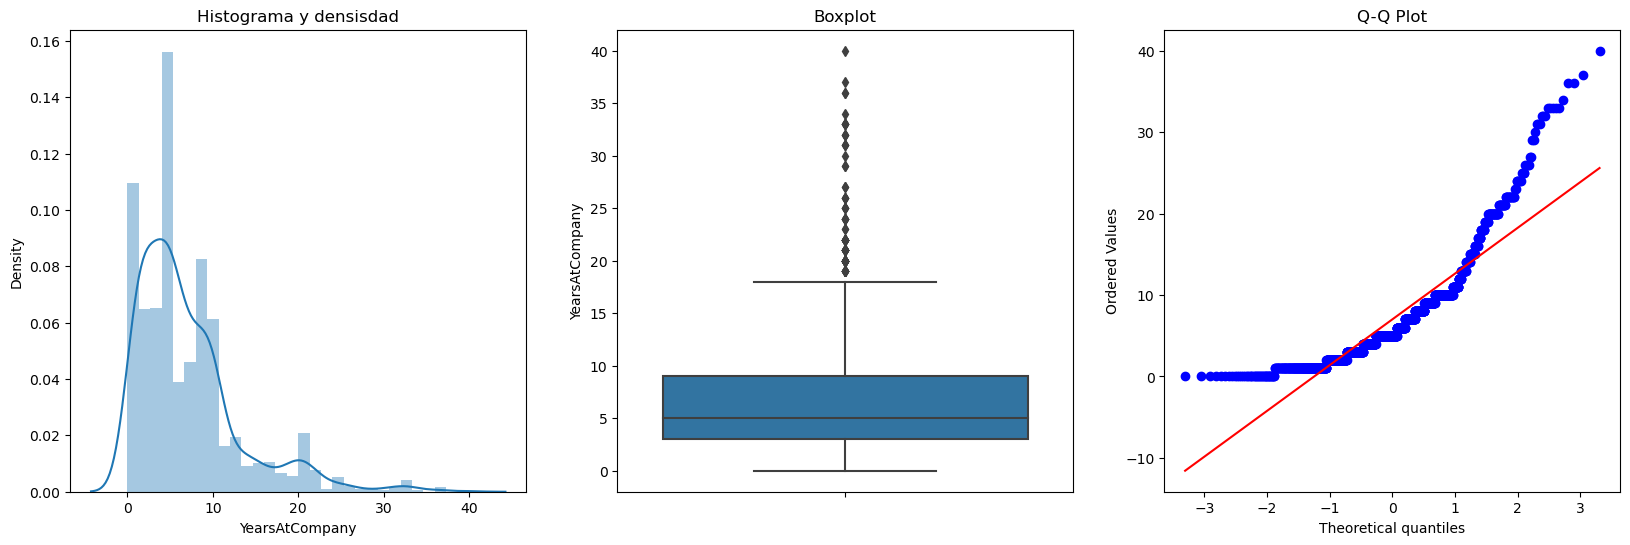

In [59]:
for col in continuas: # Se envían datos a función anterior
     plotDistBoxQQ(data_noNAN, col)

### Determinando outliers

In [60]:
def detectOutliersLimits(dataset, col): # Función que permite determinar límite superior e inferior de cada variable para detectar outliers.
     IQR = dataset[col].quantile(0.75) - dataset[col].quantile(0.25)
     LI =  np.where(dataset[col].quantile(0.25) - (IQR*1.75) < 0, 0, dataset[col].quantile(0.25) - (IQR*1.75))
     LS = dataset[col].quantile(0.75) + (IQR*1.75)

     return LI, LS

### Realizando capping a outliers

In [61]:
for col in continuas: # 
    LI, LS = detectOutliersLimits(data_noNAN, col)
    print(LI, LS)

    data_noNAN[col] = np.where(data_noNAN[col]  > LS, LS, 
                     np.where(data_noNAN[col]  < LI, LI, data_noNAN[col] ))

7.25 65.75
0.0 2334.625
0.0 3418.625
0.0 144.25
0.0 17948.0
0.0 41337.5
0.0 30.75
0.0 19.5


### Graficando columnas continuas una vez eliminados los outliers

c:\Users\Mario T\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Mario T\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Mario T\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

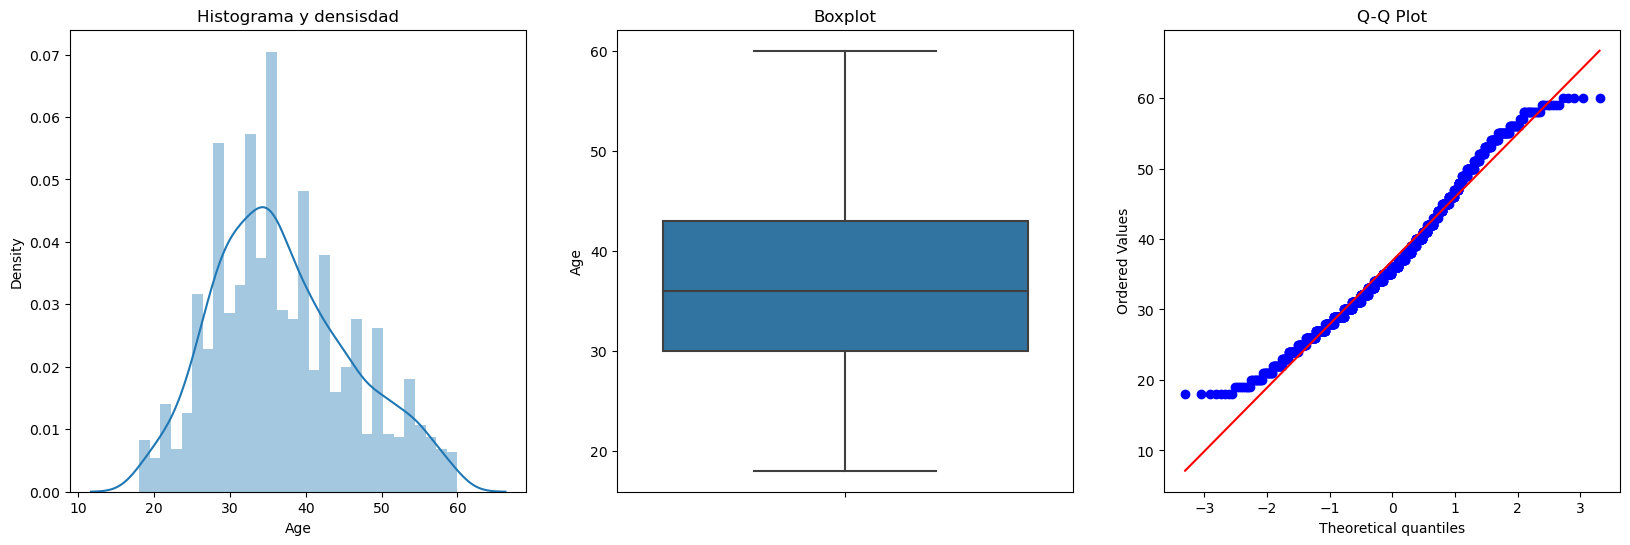

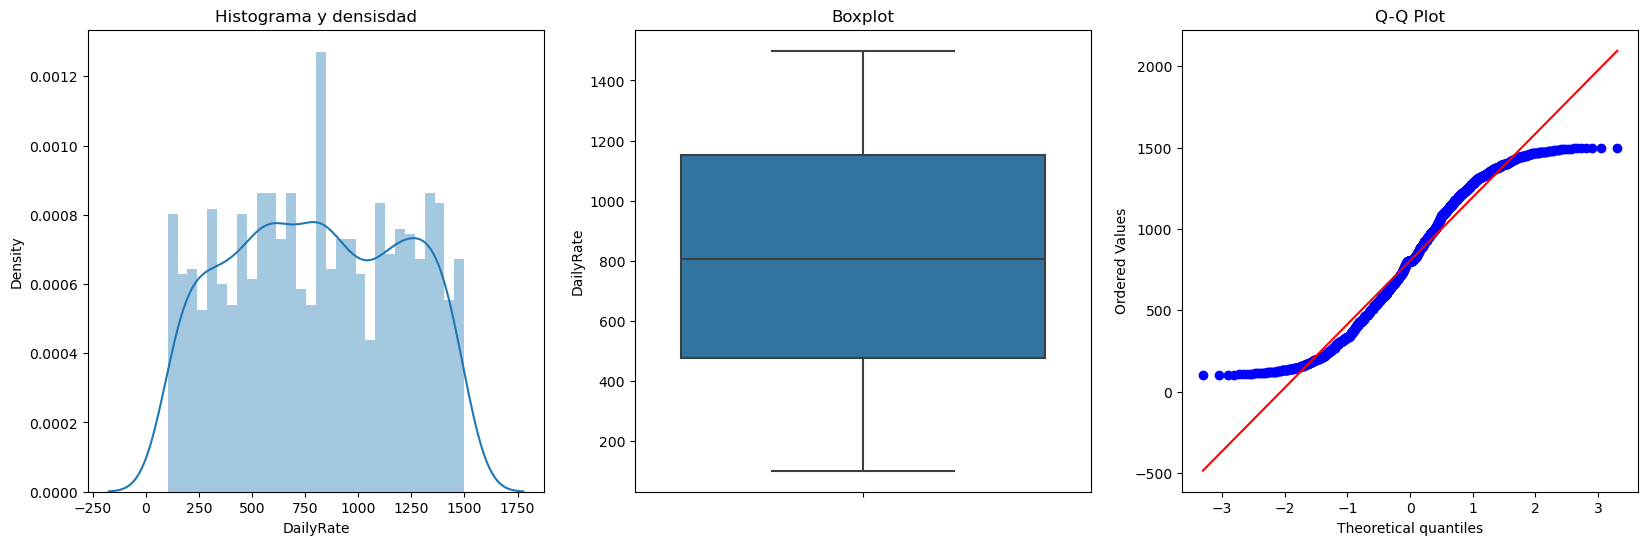

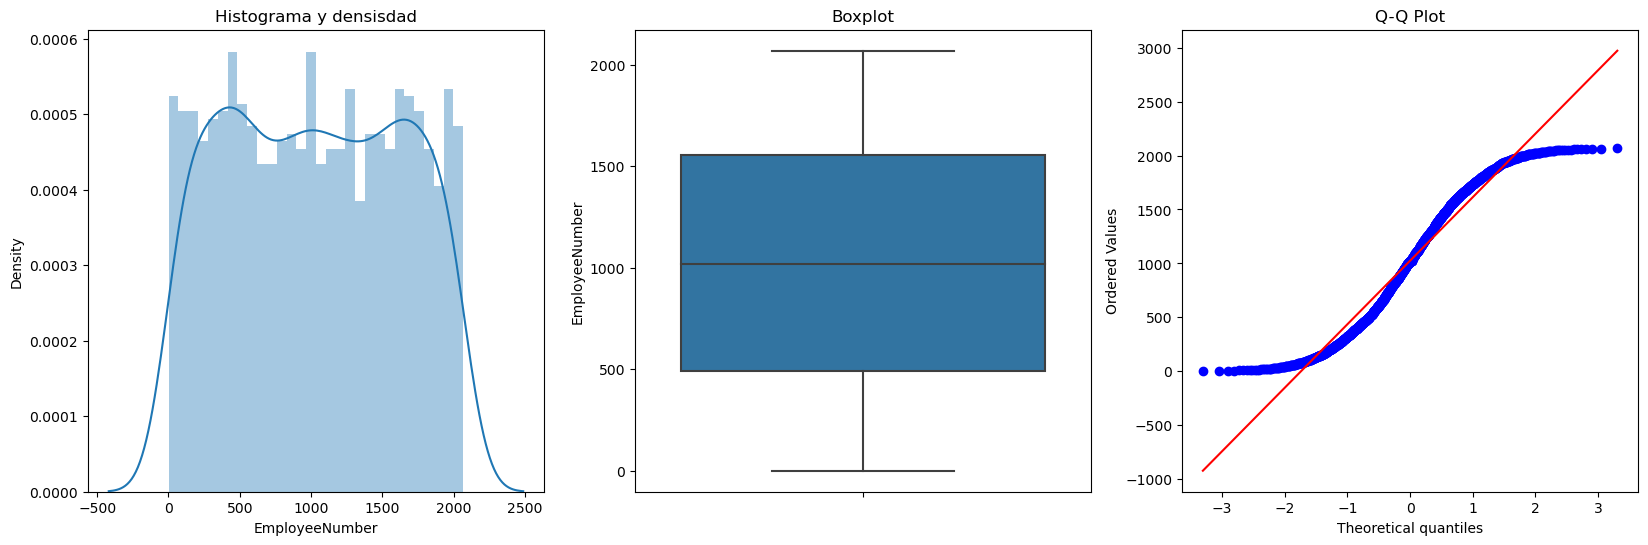

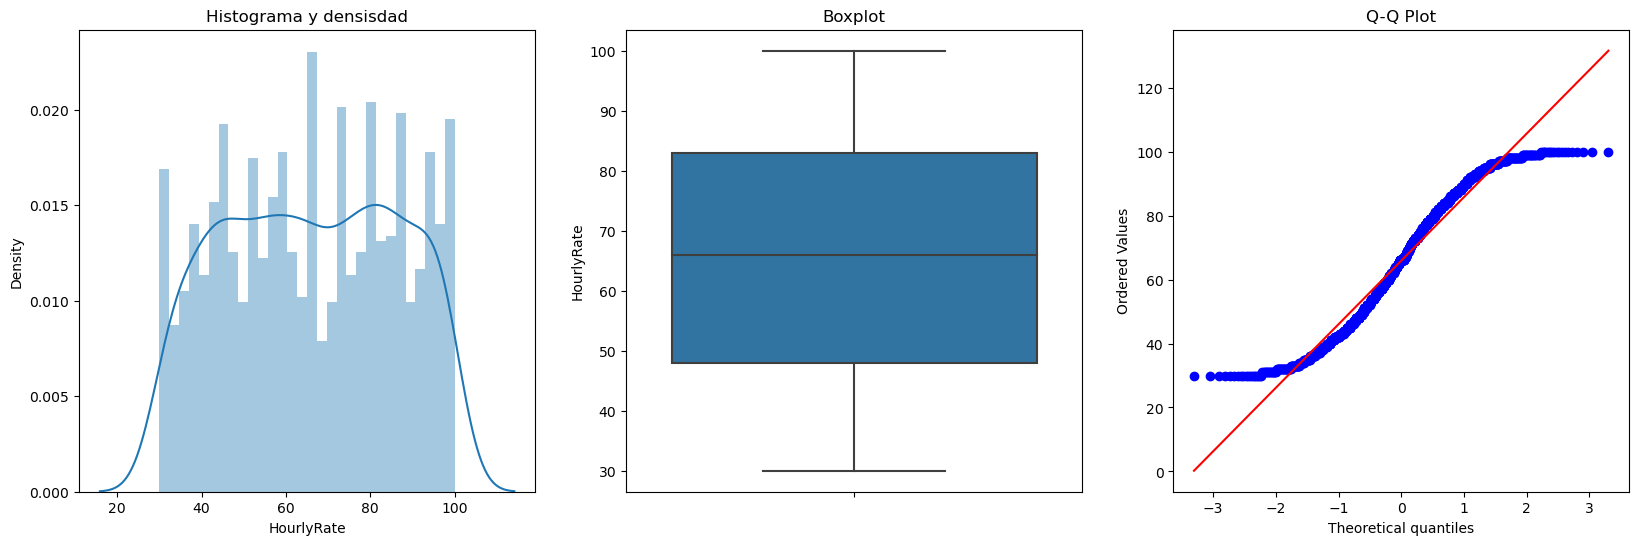

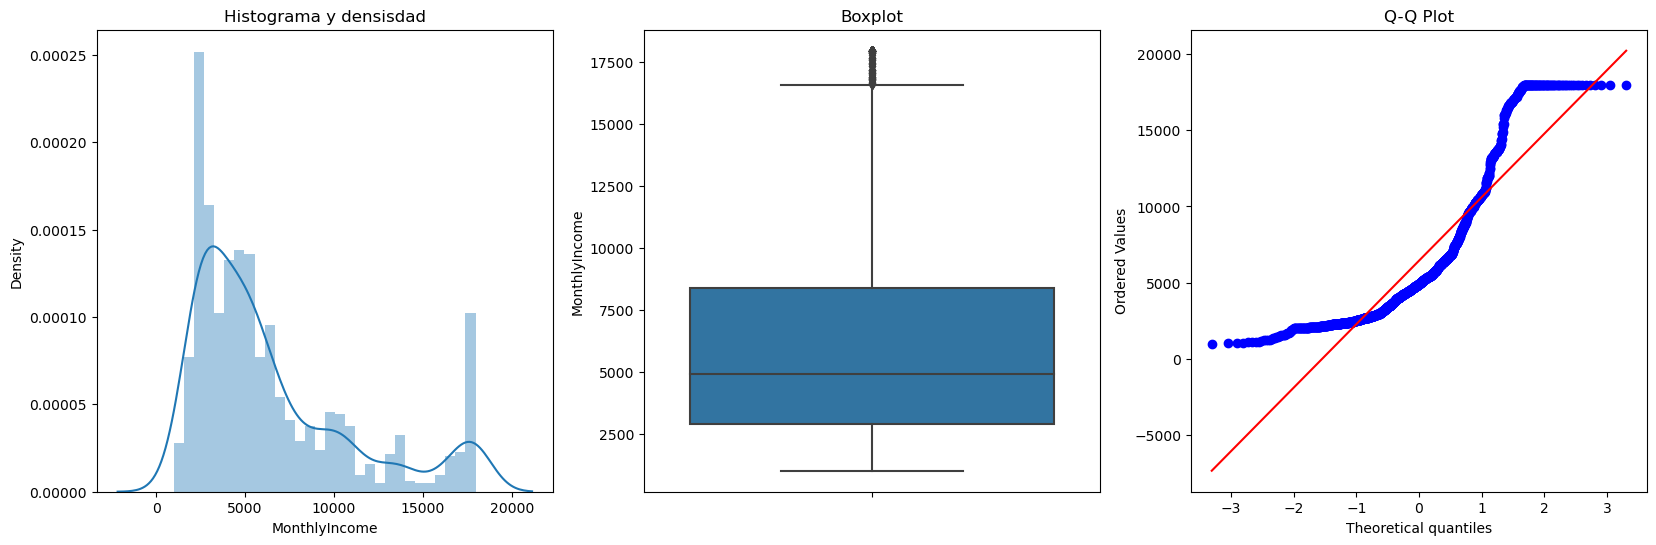

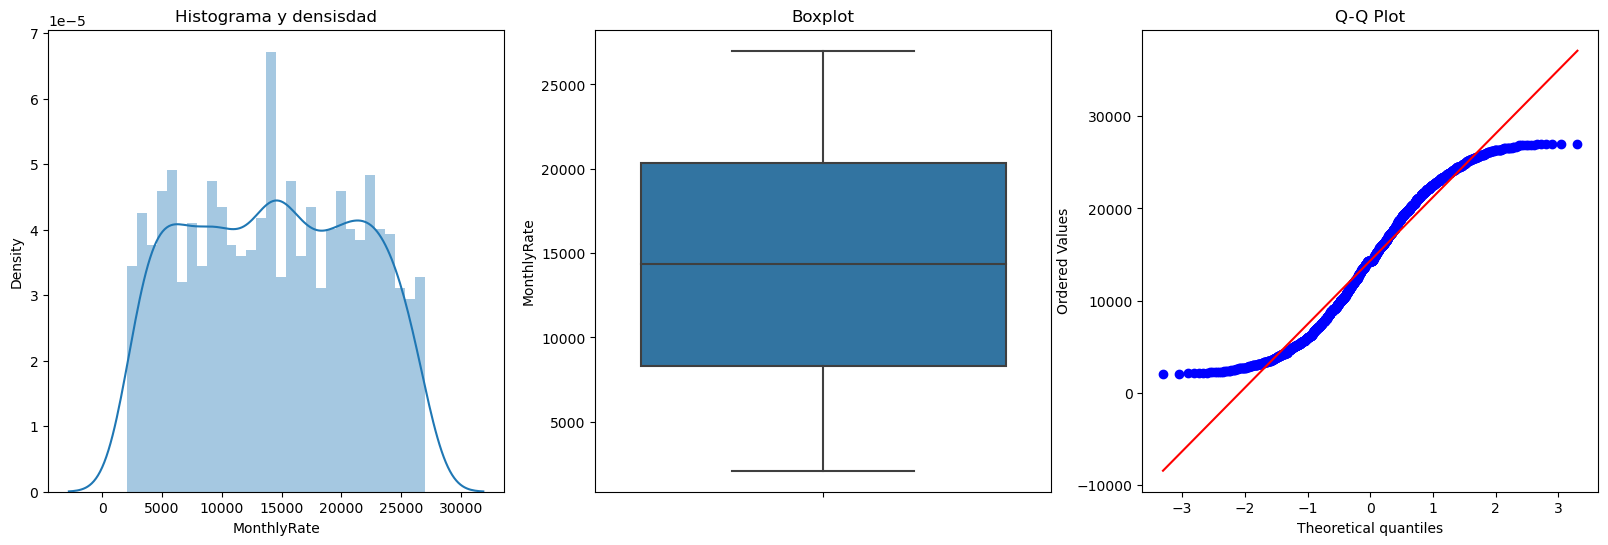

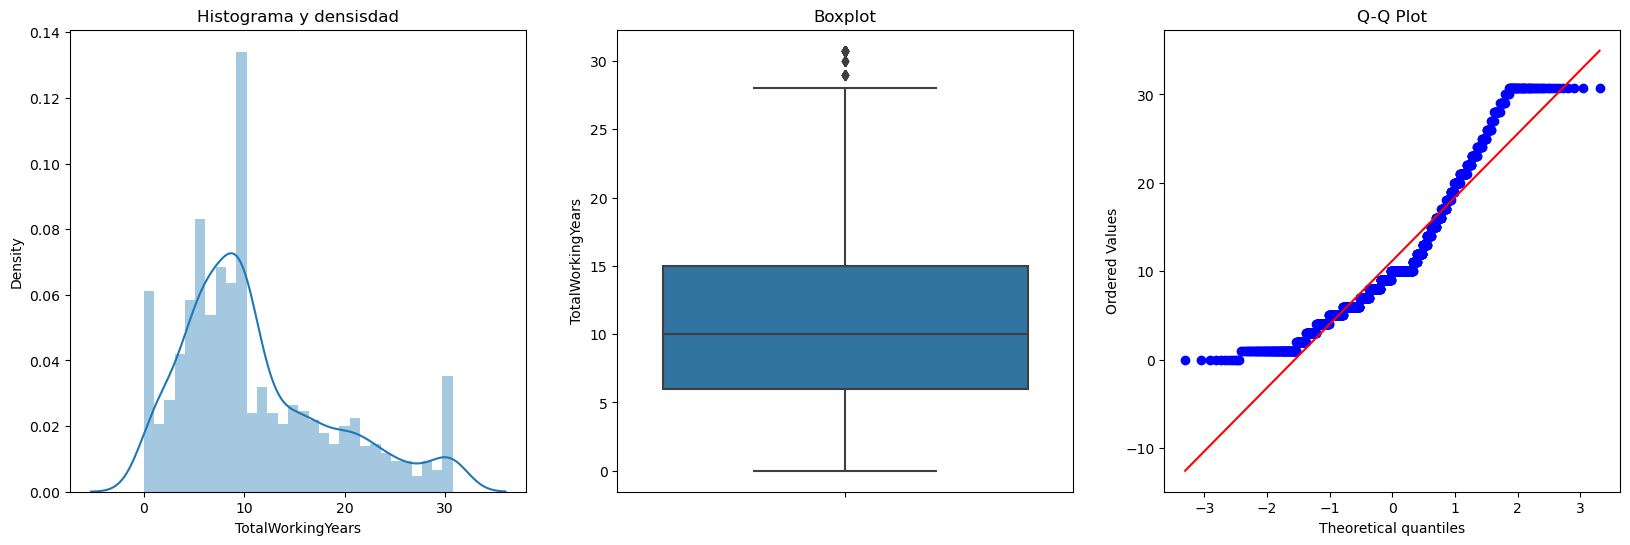

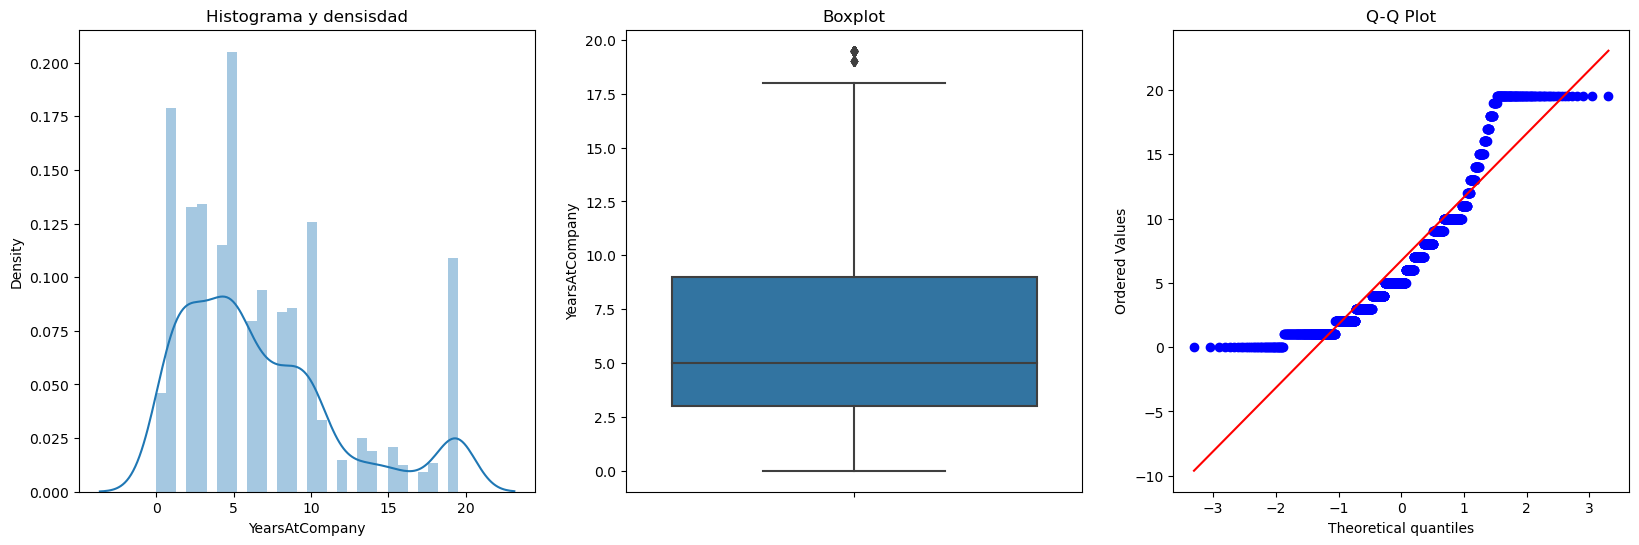

In [62]:
for col in continuas:
    plotDistBoxQQ(data_noNAN, col)

In [63]:
data_noNAN.to_csv('clean_attritions.csv', index=False)